# Problem statement
In the financial sector, we have a valued client, Atom bank, a globally recognized financial institution headquartered in the United Kingdom. With an extensive portfolio spanning banking, investments, and Crypto, they cater to a diverse clientele worldwide. However, they are currently facing a significant business challenge regarding customer feedback analysis as they have lauched a new application for crypto. Despite their widespread operations and the array of financial products and services they offer, they have observed a decline in the quantity of customer reviews and an increase in reviews expressing mixed sentiments. While customers provide feedback with both positive and negative aspects, pinpointing the exact areas for improvement, whether it relates to financial product offerings, the quality of customer service interactions, or the accessibility of services, has become an intricate task. Given their global presence, manually analyzing all these diverse customer feedback comments, has become a formidable challenge.

To tackle this issue effectively, Atom bank has decided to enlist the expertise of a data scientist to harness the power of data analytics and sentiment analysis. Their primary objective is to extract valuable insights from customer reviews and comprehend the underlying sentiments. The dataset provided by Atom includes customer reviews. Each review is accompanied by crucial information such as review head, star ratings or service ID, reviewer ID, star ratings, reviewer comments and date. The dataset comprises a total of 6000 reviews.

We are comparing the GPT2 model with the traditional machine learning models. Here, we must make predictions about each record's class based on its sentiment. How "Positive/Negative/Neutral" the record is. Our model should eventually be able to predict the classes for each record (0,1,2).



# Importing Libraries

In [2]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 7.4 MB/s eta 0:00:00


In [3]:
!pip install unidecode

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 3.0 MB/s eta 0:00:00


In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re, nltk, spacy, string
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer,TfidfVectorizer
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.corpus import wordnet
import en_core_web_sm
nlp = en_core_web_sm.load()
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
#EDA

from collections import Counter
from nltk.util import ngrams
from wordcloud import WordCloud
import contractions
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams


#nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# Loading the dataset

In [5]:
df = pd.read_csv("/content/Customer_reviews (1).csv")# read csv file/dataset

# EDA

In [6]:
df.head(3)#displays first 3 rows

,Name,Rating,Review Title,Review Text
0,Mr S Cansell,5,Great experience of Atom.,"Great experience of Atom from the very start, ..."
1,Denise,5,Straight forward clear instructions and…,Straight forward clear instructions and offeri...
2,margaret gallagher,5,All done online.was a doddle,"All done online.was a doddle, very happy with ..."


There are 6 coloumns in the dataset name, country,date_time,stars,review_head and review_body

In [7]:
df.dtypes#shows the datatypes of each coloumn

Name            object
Rating           int64
Review Title    object
Review Text     object
dtype: object

In [8]:
df.shape # shape of the dataset

(6260, 4)

There are 6260 data records and 4 coloumns

In [9]:
# select nesessary columns
df = df[['Rating', 'Review Text']]

There are 4 coloumns in the dataset, but to do the sentiment analysis we need only two coloumns i.e rating and review text.

<Axes: >

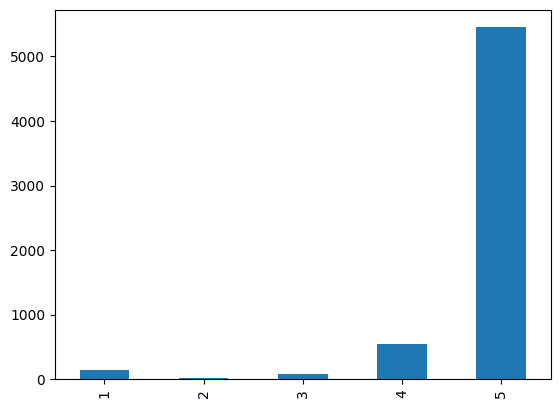

In [10]:
df.Rating.value_counts().sort_index(ascending=True).plot(kind='bar')

In this sample of data most of the customers seemed to be staisfied with the service as they have rated 5 stars but other customers have rated 1 star as well and we need to analysis.

In [11]:
# mapping the sentimentsas positive negative neutral based on the rating  value.
conditions = [
    df['Rating'] <= 2,
    df['Rating'] == 3,
    df['Rating'] >= 4
]

choices = [
    'Negative',
    'Neutral',
    'Positive'
]

df['category'] = np.select(conditions, choices, default='unknown')


In [12]:
df.head(3)

,Rating,Review Text,category
0,5,"Great experience of Atom from the very start, ...",Positive
1,5,Straight forward clear instructions and offeri...,Positive
2,5,"All done online.was a doddle, very happy with ...",Positive


A new row called category has been created to add the sentiments based on the rating value.
Maping the star ratings as POSITIVE/NEGATIVE/NEUTRAL
1. if star rating is less than or equal to 2 then assign the category as Negative.
2. if star rating is greater than or equal to 4 then assign the category as Positive.
3. if the star rating is equal to 3 then its Neutral.

In [13]:
df['category'].value_counts()

Positive    6000
Negative     174
Neutral       86
Name: category, dtype: int64

Here we can clearly see the dataset is imbalanced and need to balance the data.

# Data Preprocessing

In [14]:
import pandas as pd

# Define the remove_space function
def remove_space(data):
    if isinstance(data, str):
        removed_space = data.replace('\\n', '').replace('\\', ' ').replace('\t', ' ')
        return removed_space
    else:
        return ''  # Handle non-string values like NaN or floats by returning an empty string

# Apply the remove_space function to the 'Review_Text' column
df['cleaned_review_body'] = df['Review Text'].apply(remove_space)

# Print the resulting DataFrame with the 'cleaned_review_body' column
print(df)


      Rating                                        Review Text  category  \
0          5  Great experience of Atom from the very start, ...  Positive   
1          5  Straight forward clear instructions and offeri...  Positive   
2          5  All done online.was a doddle, very happy with ...  Positive   
3          5  I am very happy with the service provided by A...  Positive   
4          5  App is so user friendly. Customer care is frie...  Positive   
...      ...                                                ...       ...   
6255       5         Really easy and professional to deal with.  Positive   
6256       5  No fuss.  Easy to follow. Good communication. ...  Positive   
6257       5  I’ve been banking here for two years. I’ve not...  Positive   
6258       5  Good app and easy to navigate site. Best 1yr r...  Positive   
6259       5  Everything about Atom is easy!! The app is eas...  Positive   

                                    cleaned_review_body  
0     Great exper

the above code is used to remove the nextline and tab spaces.

In [15]:
### Contractions

def expand_text(data):
    expanded_text = contractions.fix(data)
    return expanded_text

In [16]:
df['cleaned_review_body'] = df['cleaned_review_body'] .apply(expand_text)

The above code is used to expand the contracted words to get the right meaning from those sentence.

In [17]:
### Accented data

def accented_word(data):
    remove_acceted_text = unidecode(data)
    return remove_acceted_text

In [18]:
df['cleaned_review_body'] = df['cleaned_review_body'] .apply(accented_word)

In [19]:
### Stopwords and Cleaning

stopword_list = stopwords.words('english')
stopword_list.remove('not')
stopword_list.remove('nor')
stopword_list.remove('no')


Removing the stopwords like not,nor and no from the sentence.

In [20]:
# tokenization
def clean_data(data):
    tokens = word_tokenize(data)
    cleaned_text = [word.lower() for word in tokens if (word not in punctuation) and
                    (word.lower() not in stopword_list) and (word.isalpha()) and len(word)>2 ]
    return cleaned_text

In [21]:
df['cleaned_review_body'] = df['cleaned_review_body'] .apply(clean_data)

The above code is used to tokensize the data or create tokens.

## Lemmatization

In [22]:
### Lemmatization

def lemmatization(data):
    lemmatizer = WordNetLemmatizer()
    final_data = []

    for word in data:
        lemmatizer_word = lemmatizer.lemmatize(word)
        final_data.append(lemmatizer_word)
    return ' '.join(final_data)

In [23]:
df['cleaned_review_body'] = df['cleaned_review_body'] .apply(lemmatization)

Lemmetizing the words into their base for in order to reduce it into their base forms.

In [24]:
df.head()

,Rating,Review Text,category,cleaned_review_body
0,5,"Great experience of Atom from the very start, ...",Positive,great experience atom start easy process open ...
1,5,Straight forward clear instructions and offeri...,Positive,straight forward clear instruction offering go...
2,5,"All done online.was a doddle, very happy with ...",Positive,done doddle happy atom interest rate best took...
3,5,I am very happy with the service provided by A...,Positive,happy service provided atom app clear easy pro...
4,5,App is so user friendly. Customer care is frie...,Positive,app user friendly customer care friendly effic...


## Unigrams after Data cleaning

In [25]:
def ngrams_extractor(data, ngram_range):
    tokens = word_tokenize(data)
    ngram_text = ngrams(tokens, ngram_range)
    ngram_list = []

    for ngram in ngram_text:
        ngram_list.append(' '.join(ngram))
    return ngram_list

In [26]:
unigrams_df = df['cleaned_review_body'].apply(lambda i : ngrams_extractor(i,1))


final_unigram = []

for unigram in unigrams_df:
    final_unigram.extend(unigram)
count_unigram = Counter(final_unigram).most_common(25)
count_unigram


[('easy', 4323),
 ('account', 3772),
 ('rate', 2947),
 ('app', 2372),
 ('atom', 2164),
 ('interest', 1932),
 ('use', 1553),
 ('bank', 1525),
 ('good', 1492),
 ('saving', 1379),
 ('set', 1215),
 ('not', 1146),
 ('open', 1121),
 ('simple', 966),
 ('great', 914),
 ('money', 835),
 ('fixed', 754),
 ('service', 594),
 ('year', 592),
 ('would', 575),
 ('really', 571),
 ('competitive', 533),
 ('process', 511),
 ('transfer', 481),
 ('recommend', 480)]

Now that the data had been properly prepared, I examined the number of trigrams, bigrams, and unigrams in each page again. to comprehend what the most common phrases are that are used the majority of the time.

## Bigram

In [27]:
bigram_df = df['cleaned_review_body'].apply(lambda i : ngrams_extractor(i,2))

final_bigram = []

for bigram in bigram_df:
    final_bigram.extend(bigram)

count_bigram = Counter(final_bigram).most_common(25)
count_bigram

[('interest rate', 1288),
 ('easy use', 988),
 ('easy set', 776),
 ('easy open', 610),
 ('saving account', 580),
 ('atom bank', 557),
 ('open account', 546),
 ('app easy', 414),
 ('use app', 313),
 ('good interest', 281),
 ('good rate', 264),
 ('fixed rate', 263),
 ('set account', 257),
 ('really easy', 249),
 ('account easy', 244),
 ('customer service', 242),
 ('account atom', 241),
 ('rate interest', 238),
 ('straight forward', 214),
 ('saving rate', 199),
 ('opening account', 188),
 ('quick easy', 168),
 ('easy access', 168),
 ('great interest', 167),
 ('would recommend', 156)]

## Trigrams

In [28]:
trigram_df = df['cleaned_review_body'].apply(lambda i : ngrams_extractor(i,3))

final_trigram = []

for trigram in trigram_df:
    final_trigram.extend(trigram)

count_trigram = Counter(final_trigram).most_common(25)
count_trigram

[('easy open account', 323),
 ('app easy use', 254),
 ('good interest rate', 249),
 ('easy use app', 239),
 ('easy set account', 176),
 ('great interest rate', 155),
 ('competitive interest rate', 136),
 ('good rate interest', 105),
 ('best interest rate', 85),
 ('saving account atom', 75),
 ('would highly recommend', 66),
 ('really easy set', 66),
 ('interest rate easy', 66),
 ('high street bank', 64),
 ('open saving account', 63),
 ('account easy set', 57),
 ('interest rate competitive', 54),
 ('interest rate good', 54),
 ('really easy open', 54),
 ('fixed saving account', 53),
 ('would definitely recommend', 52),
 ('open account app', 52),
 ('fixed rate account', 52),
 ('really easy use', 51),
 ('easy set use', 49)]

## Wordcloud

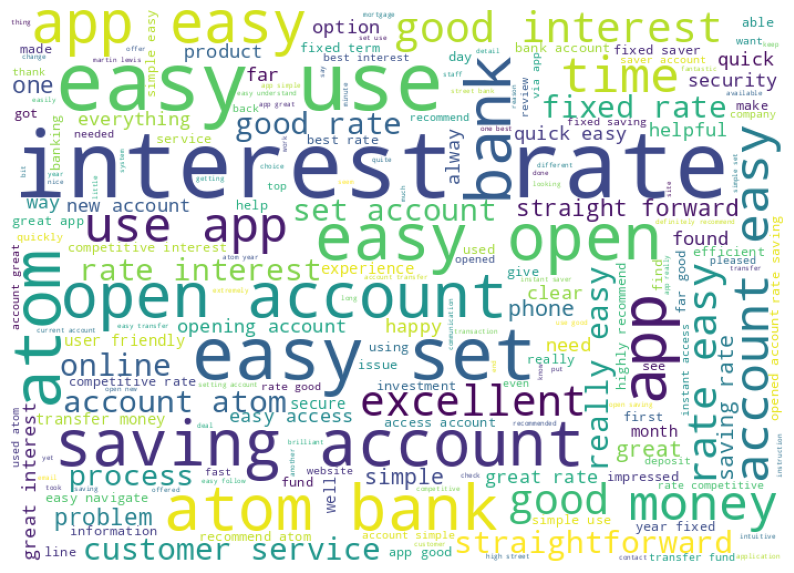

In [29]:
def wordcloud(data, column):
    df_ = data[column].str.cat(sep = ' ')
    text = ' '.join([word for word in df_.split()])

    wordcloud = WordCloud(width = 700, height = 500, background_color = 'white').generate(text)

    plt.figure(figsize = (10,15))
    plt.imshow(wordcloud)
    plt.axis('off')

wordcloud(df, 'cleaned_review_body')

Wordcloud offers a thorough understanding of the sentiment of the dataset. with more frequent words appearing larger and more prominent.

## removing null values

In [30]:
df["cleaned_review_body"] = df["cleaned_review_body"].apply(lambda x : np.nan if re.search("^[\s]*$", x) else x)
df = df[~(df["cleaned_review_body"].isnull())]
df.shape

(5655, 4)

In [31]:
df.head()

,Rating,Review Text,category,cleaned_review_body
0,5,"Great experience of Atom from the very start, ...",Positive,great experience atom start easy process open ...
1,5,Straight forward clear instructions and offeri...,Positive,straight forward clear instruction offering go...
2,5,"All done online.was a doddle, very happy with ...",Positive,done doddle happy atom interest rate best took...
3,5,I am very happy with the service provided by A...,Positive,happy service provided atom app clear easy pro...
4,5,App is so user friendly. Customer care is frie...,Positive,app user friendly customer care friendly effic...


In [32]:
df = df[['category', 'cleaned_review_body']]

Considering only necessary coloumns for model building and removing unnecessary coloumns

In [33]:
df.head(100)

,category,cleaned_review_body
0,Positive,great experience atom start easy process open ...
1,Positive,straight forward clear instruction offering go...
2,Positive,done doddle happy atom interest rate best took...
3,Positive,happy service provided atom app clear easy pro...
4,Positive,app user friendly customer care friendly effic...
...,...,...
95,Positive,app really good everything really simple set i...
96,Positive,good rate easy navigate new account via app
97,Positive,atom keep date information regarding account f...
98,Positive,easy navigate online happy interest offered ex...


Here we can see there is some rows with none in reviews which is not usefull for us hence removing the none values

In [34]:
df = df[df['cleaned_review_body'] != 'none']

In [35]:
df.head(20)

,category,cleaned_review_body
0,Positive,great experience atom start easy process open ...
1,Positive,straight forward clear instruction offering go...
2,Positive,done doddle happy atom interest rate best took...
3,Positive,happy service provided atom app clear easy pro...
4,Positive,app user friendly customer care friendly effic...
5,Positive,atom bank couple year mortgage customer always...
6,Positive,called atom bank order address updated provide...
7,Positive,customer service think could add money monthly...
8,Positive,started using atom bank looking bank offering ...
9,Positive,really good transfer money immediately excelle...


In [36]:
df.to_csv('processed_reviews.csv', index=False)

Converting the processed dataframe into the csv file for model building.